In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
! pip install -q pyspark==3.3.0 spark-nlp==4.2.8

In [41]:
! pip install seaborn

In [42]:
import json
import pandas as pd
import numpy as np
import re
import sparknlp
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from sparknlp.annotator import *
from sparknlp.base import *
from sparknlp.pretrained import PretrainedPipeline
from pyspark.sql.functions import udf, col, explode, when, concat_ws, count
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.ml.feature import StopWordsRemover, Tokenizer

In [10]:
spark = sparknlp.start()
print ("Spark NLP Version :", sparknlp.version())
spark

Spark NLP Version : 4.2.8


In [13]:
df = spark.read.parquet('/content/drive/MyDrive/Machine Learning/Bigdata/final_project/trump_biden_sentiment.parquet')

In [15]:
df.show(20)

+-------------------+--------------------+--------------------+-----+-------------+-------------------+--------------------+--------------------+----------------+--------------------+-------------------+--------------------+--------------------+------------------+-------------------+-------------+--------------------+-------------+------------+----------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+--------------+-------------+---------+
|         created_at|            tweet_id|               tweet|likes|retweet_count|             source|             user_id|           user_name|user_screen_name|    user_description|     user_join_date|user_followers_count|       user_location|               lat|               long|         city|             country|    continent|       state|state_code|        collected_at|   candidate|            document| sentence_embeddings|            language|      sentiment_view|          

###Remove stop words and Count the hot key words


In [16]:
df = df.filter(col('retweet_count') > 1)

# tweets = df.select("tweet").rdd.flatMap(lambda x: x).collect() #output [ , , , ]

In [17]:
df = df.withColumn("tweet", when(col("tweet").isNull(), "").otherwise(col("tweet")))

Remove stop words

In [18]:
tokenizer = Tokenizer(inputCol="tweet", outputCol="words")

df_tokens = tokenizer.transform(df)

# Create StopWordsRemover instance
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

# Get a default list of English stop words
stop_words = remover.getStopWords()

# Apply StopWordsRemover to remove stop words
df = remover.transform(df_tokens)

# check result
df.select("filtered_words").show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|filtered_words                                                                                                                                                                                                                                                                         |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[describe, #joebiden, #kamalaharris, one, 1️⃣, word~, , right, now., , say, ‘excited’, 😃., https://t.co/1ohfmt9mnp]                                      

In [19]:
def clean_additional(text):
    cleaned_words = []
    for word in text:
        word = re.sub(r'https?:\/\/\S+', '', word) #remove URL
        word = re.sub(r'@\w+|#\w+', '', word) #remove @mention or #tag
        # word = re.sub("\U0001F300-\U0001F5FF-\U0001F600-\U0001F64F-\U0001F680-\U0001F6FF-\U0002600-\U00026FF-\U0002700-\U00027BF", '', word) #remove emoji
        word = re.sub(r'\d+', '', word) #remove number
        word = re.sub(r'[^a-zA-Z\s]', '', word)  # remove non-English characters
        if len(word) >= 2:
            cleaned_words.append(word.lower()) #convert uppercase to lowercase
    return cleaned_words

clean_additional_udf = udf(clean_additional, ArrayType(StringType()))


In [20]:
df_cleaned = df.withColumn('cleaned_words', clean_additional_udf(col('filtered_words')))

df_cleaned.select("cleaned_words").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|cleaned_words                                                                                                                                                                             |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[describe, one, word, right, now, say, excited]                                                                                                                                           |
|[run, pro, ad, warning, raise, middle, classand, wants, buy]                                                                                                                              |
|[hahahaha, joe, biden, blocked, me, didnt, actually, t

Recognize English tweet


In [21]:
# Combine the lists into a single string, using spaces as separators
df = df_cleaned.withColumn("text", concat_ws(" ", "cleaned_words"))


In [22]:
# model_name = 'ld_wiki_cnn_231'
model_name = 'ld_wiki_tatoeba_cnn_375'

documentAssembler = DocumentAssembler()\
            .setInputCol("text")\
            .setOutputCol("document")

sentence_detector = SentenceDetector() \
            .setInputCols(["document"]) \
            .setOutputCol("sentence")

languageDetector = LanguageDetectorDL.pretrained(model_name)\
            .setInputCols("sentence")\
            .setOutputCol("language")\
            .setThreshold(0.5)\
            .setCoalesceSentences(True)

nlpPipeline = Pipeline(
    stages=[
        documentAssembler,
        sentence_detector,
        languageDetector])


ld_wiki_tatoeba_cnn_375 download started this may take some time.
Approximate size to download 8.8 MB
[OK!]


In [23]:
result = nlpPipeline.fit(df).transform(df)

result.select(F.explode(F.arrays_zip(result.document.result,
                                     result.language.result)).alias("cols")) \
      .select(F.expr("cols['0']").alias("Document"),
              F.expr("cols['1']").alias("Language")).show(truncate=100)

+----------------------------------------------------------------------------------------------------+--------+
|                                                                                            Document|Language|
+----------------------------------------------------------------------------------------------------+--------+
|                                                             describe one word right now say excited|      en|
|                                                  run pro ad warning raise middle classand wants buy|      en|
|hahahaha joe biden blocked me didnt actually twitter partners it really pathetic think it im aver...|      en|
|                          massive thousands cars people support everywhere streets amp sides streets|      en|
|                                  proud supporters supporters biden rally worked closed plant closed|      en|
|                           democracy works vote counted dont care hard people try stop it let happen|  

In [24]:
# result.printSchema() #show the result data structure

In [25]:
english_documents = result.filter(col("Language").getItem(0).getField("result") == "en")

In [26]:
# english_documents.printSchema() #show the english_documents data structure

In [27]:
english_text = english_documents.withColumn("document", explode(col("document")))

english_text = english_text.withColumn("text", col("document.result"))

english_text.select("text").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|describe one word right now say excited                                                                                                                             |
|run pro ad warning raise middle classand wants buy                                                                                                                  |
|hahahaha joe biden blocked me didnt actually twitter partners it really pathetic think it im average dude blocked me im honored blocked thanks                      

In [28]:
tokenizer = Tokenizer(inputCol="text", outputCol="splits_words")

# Apply Tokenizer for word segmentation
df_words = tokenizer.transform(english_text)

# Display the word segmentation results to ensure correct word segmentation
df_words.select("splits_words").show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|splits_words                                                                                                                                                                              |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[describe, one, word, right, now, say, excited]                                                                                                                                           |
|[run, pro, ad, warning, raise, middle, classand, wants, buy]                                                                                                                              |
|[hahahaha, joe, biden, blocked, me, didnt, actually, t

In [29]:
# df_words.printSchema()

In [30]:
df_word_count = df_words.withColumn("splits_words", explode(col("splits_words")))\
                        .groupBy(('splits_words')).count()\
                        .orderBy('count', ascending=False)

df_word_count.show(20)

+------------+-----+
|splits_words|count|
+------------+-----+
|         amp| 4466|
|       trump| 3119|
|   president| 2331|
|        vote| 2218|
|       biden| 2091|
|      people| 1877|
|        like| 1822|
|          us| 1791|
|    election| 1740|
|         get| 1499|
|         one| 1475|
|       votes| 1356|
|         win| 1320|
|        know| 1207|
|         its| 1204|
|         joe| 1204|
|          it| 1160|
|       going| 1031|
|     america| 1008|
|        time|  947|
+------------+-----+
only showing top 20 rows



##Hot key words Visualization

In [31]:
!pip install matplotlib seaborn


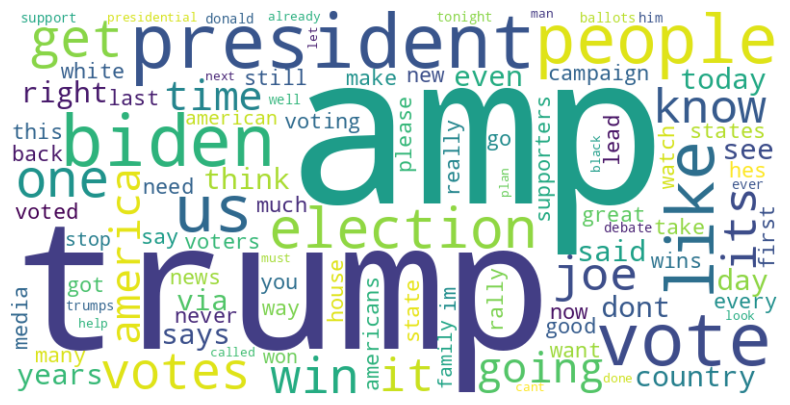

In [32]:

!pip install matplotlib
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt


word_freq = df_word_count.limit(100).rdd.map(lambda row: (row['splits_words'], row['count'])).collect()
word_freq_dict = dict(word_freq)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

# Display it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


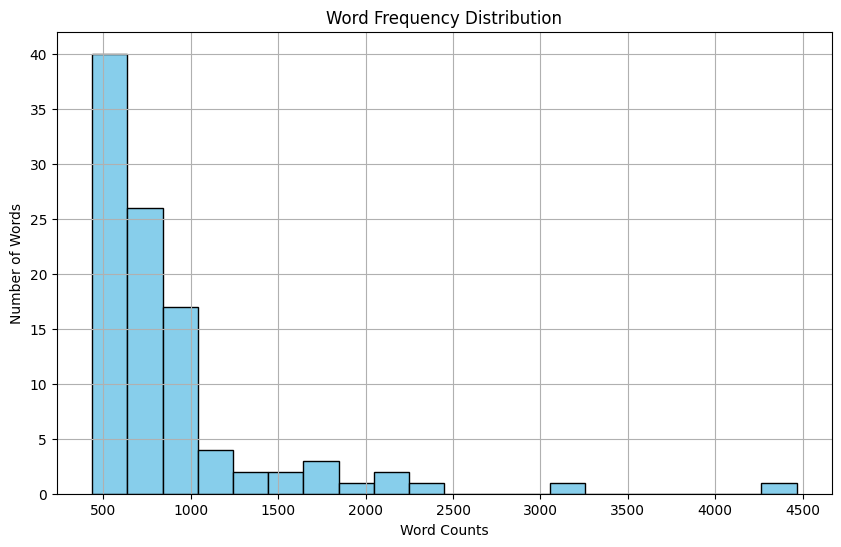

In [33]:
import matplotlib.pyplot as plt

word_counts = df_word_count.limit(100).select('count').rdd.flatMap(lambda x: x).collect()

plt.figure(figsize=(10, 6))
plt.hist(word_counts, bins=20, color='skyblue', edgecolor='black')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Counts')
plt.ylabel('Number of Words')
plt.grid(True)
plt.show()

In [34]:
keywords_distribution = df_word_count.select(explode(col("cleaned_words")).alias("keyword")).groupBy("keyword").count().orderBy(col("count").desc())
keywords_distribution.show()

+---------+-----+
|  keyword|count|
+---------+-----+
|      amp| 4760|
|    trump| 3486|
|president| 2579|
|    biden| 2544|
|     vote| 2516|
|   people| 2009|
|     like| 1908|
|       us| 1891|
| election| 1853|
|      get| 1595|
|      one| 1559|
|      joe| 1509|
|    votes| 1459|
|      win| 1453|
|     know| 1254|
|       it| 1208|
|      its| 1204|
|  america| 1138|
|      via| 1119|
|    going| 1087|
+---------+-----+
only showing top 20 rows



In [35]:
keywords_distribution_pd = keywords_distribution.toPandas()

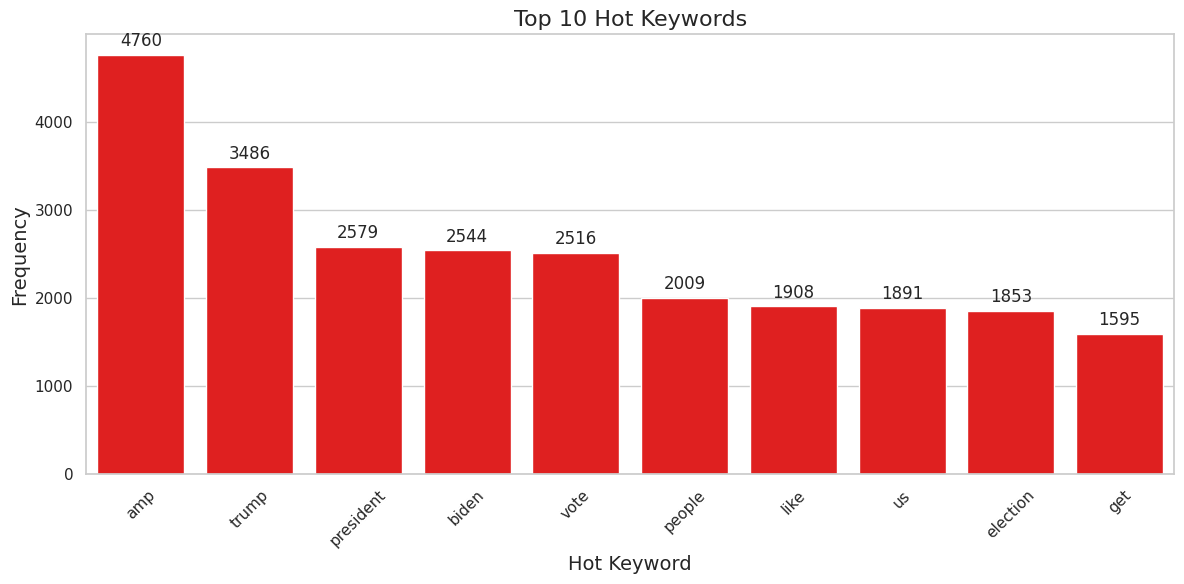

In [43]:
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

ax = sns.barplot(x='keyword', y='count', data=keywords_distribution_pd.head(10), color='red')

ax.set_title('Top 10 Hot Keywords', fontsize=16)
ax.set_xlabel('Hot Keyword', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),  # Format labels using integers
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),  # Set the position offset of the text
                textcoords = 'offset points')

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()